# Imports

In [1]:
import spacy
import pandas as pd
import numpy as np
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.vectors import Vectors
from tqdm import tqdm
tqdm.pandas()


In [2]:
df = pd.read_csv("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_reports.csv")
df["subject"] = df["subject"].fillna("Other")
df

,text,subject
0,"Since its inception in 2010, we have distribut...",Social
1,"I will focus first on traffic, which is a key ...",Other
2,"Also, many farms are aged with degraded soil t...",Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social
4,The company’s U.S. GOM operations can be impac...,Other
...,...,...
2180,American shad are a species of concern for res...,Environmental
2181,Weyerhaeuser's policies address best practices...,Other
2182,compares recently observed trends in weather p...,Environmental
2183,"If our partners, including our licensors, suff...",Other


## Get data

In [3]:
for i in range(10,15):
    print(df.iloc[i])

text       We worked closely with our portfolio companies...
subject                                               Social
Name: 10, dtype: object
text       His typical day includes customer calls and vi...
subject                                               Social
Name: 11, dtype: object
text       Climate Adaptation Market: A large part of our...
subject                                        Environmental
Name: 12, dtype: object
text       In determining fair value for land held for sa...
subject                                                Other
Name: 13, dtype: object
text       More than 165 stakeholders were interviewed to...
subject                                               Social
Name: 14, dtype: object


We'll use the following example sentence

In [4]:
sentence = df.iloc[67]
sentence.text

'Our Logistics We maintain a full-line wholesale and logistics facility in Alabaster, Alabama (a suburb of Birmingham) where we receive and ship most our merchandise.'

## Clean data

In [5]:
punctuations = string.punctuation

nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence["text"].lower())

    # Remove OOV words
    mytokens = [ word for word in mytokens if not word.is_oov ]
    
    # Lemmatise + lower case
    mytokens = [ word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

spacy_tokenizer(sentence)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['logistic',
 'maintain',
 'line',
 'wholesale',
 'logistic',
 'facility',
 'alabaster',
 'alabama',
 'suburb',
 'birmingham',
 'receive',
 'ship',
 'merchandise']

## Calculate word frequencies

In [6]:
from collections import Counter

tokenFreq = Counter()

def countWordFrequencies(example):
    tokens = spacy_tokenizer(example)
    tokenFreq.update(tokens)
    
df.progress_apply(countWordFrequencies, axis=1)


100%|███████████████████████████████████████████████████████████████████| 2185/2185 [00:17<00:00, 127.69it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
2180    None
2181    None
2182    None
2183    None
2184    None
Length: 2185, dtype: object

In [7]:
tokenFreq.total()

39095

In [8]:
len(tokenFreq.keys())

5529

In [9]:
VOCAB_SIZE = 1000

In [10]:
print("Most frequent")
print(tokenFreq.most_common(10))
print("Least frequent")
print(tokenFreq.most_common(VOCAB_SIZE)[-10:])


Most frequent
[('water', 527), ('use', 320), ('include', 298), ('energy', 275), ('company', 232), ('forest', 229), ('environmental', 223), ('product', 213), ('management', 178), ('operation', 162)]
Least frequent
[('relevant', 8), ('80', 8), ('livestock', 8), ('insect', 8), ('tenant', 8), ('cocoa', 8), ('recover', 8), ('borrower', 8), ('disturbance', 8), ('contribution', 8)]


In [11]:
tokenMap = {k: i+1 for i, (k, _) in enumerate(tokenFreq.most_common(VOCAB_SIZE-1))}
tokenMap["<oov>"]=0
tokenMapInverse = {v: k for k,v in tokenMap.items()}
print(list(tokenMap.items())[0:10])
print([tokenMapInverse[i] for i in range(10)])

[('water', 1), ('use', 2), ('include', 3), ('energy', 4), ('company', 5), ('forest', 6), ('environmental', 7), ('product', 8), ('management', 9), ('operation', 10)]
['<oov>', 'water', 'use', 'include', 'energy', 'company', 'forest', 'environmental', 'product', 'management']


## Simple model - BOW

In [12]:
def embed_sentence_BOW(example):
    """
    Simple BOW
    """
    embedding = np.zeros(VOCAB_SIZE)
    tokens = spacy_tokenizer(example)
    for token in tokens:
        try:
            tokenIndex = tokenMap[token]
        except KeyError: # Out of vocabulary
            tokenIndex = 0
        embedding[tokenIndex] = embedding[tokenIndex] + 1
    return embedding
    
sentence = df.iloc[302]
sentence_embedding = embed_sentence_BOW(sentence)

print(sentence_embedding)
print(sentence_embedding.shape)
print(sentence)
print("What this means: ")

for i in range(VOCAB_SIZE):
    if sentence_embedding[i]:
        print(f"Token {i} '{tokenMapInverse[i]}' occurs {sentence_embedding[i]} time in sentence.")

[2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [13]:
df["embedding"] = df.progress_apply(embed_sentence_BOW, axis=1)
df

100%|███████████████████████████████████████████████████████████████████| 2185/2185 [00:15<00:00, 137.62it/s]


,text,subject,embedding
0,"Since its inception in 2010, we have distribut...",Social,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"I will focus first on traffic, which is a key ...",Other,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Also, many farms are aged with degraded soil t...",Environmental,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social,"[7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,The company’s U.S. GOM operations can be impac...,Other,"[9.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
2180,American shad are a species of concern for res...,Environmental,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2181,Weyerhaeuser's policies address best practices...,Other,"[6.0, 0.0, 1.0, 3.0, 0.0, 1.0, 3.0, 0.0, 1.0, ..."
2182,compares recently observed trends in weather p...,Environmental,"[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2183,"If our partners, including our licensors, suff...",Other,"[3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


## Classify

In [14]:
X = np.stack(df["embedding"])
X.shape

(2185, 1000)

In [15]:
X[302:303,]

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [16]:
y = np.array(df["subject"])
y

array(['Social', 'Other', 'Environmental', ..., 'Environmental', 'Other',
       'Other'], dtype=object)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1638, 1000)
X_test shape: (547, 1000)
y_train shape: (1638,)
y_test shape: (547,)


In [19]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=22141, class_weight="balanced", n_estimators=300)
clf.fit(X_train, y_train)

print("Done")

Done
CPU times: user 252 ms, sys: 29.8 ms, total: 282 ms
Wall time: 350 ms


## Evaluate

In [31]:
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from matplotlib import pyplot as plt
import datetime
from tabulate import tabulate

def log_experiment_results(experiment_name, stats, filename="experiment_log.md"):
    """
    Appends experiment results and statistics to a markdown log file.
    
    Parameters:
    - experiment_name: str, the name of the experiment
    - stats: dict, a dictionary containing the statistics to log
    - filename: str, the path to the log file
    """
    stats["timestamp"] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
    stats["Experiment Name"] = experiment_name
    try:
        
        df = pd.read_table(filename, sep="|", skipinitialspace=True).drop(0)
        df.columns = df.columns.str.strip()
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        
    except (FileNotFoundError, pd.errors.EmptyDataError, pd.errors.ParserError):
        df = pd.DataFrame(columns=list(stats.keys()))
    
    df = pd.concat([df, pd.DataFrame([stats])], ignore_index=True)
    df = df[["precision", "recall", "f1-score", "support", "timestamp", "Experiment Name"]]
    markdown_table = tabulate(df, headers='keys', tablefmt='pipe', showindex=False, floatfmt=(".3g"), intfmt=",")
    with open(filename, 'w') as f:
        f.write(markdown_table)

def evaluate_model(y_test, predictions, clf):
    stats = classification_report(y_test, predictions, output_dict=True)
    print(classification_report(y_test, predictions))
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, predictions),
        display_labels=clf.classes_,
    )
    
    cmp.plot(ax=ax)
    plt.show()
    return stats

Enter experiment name:  bow


               precision    recall  f1-score   support

Environmental       0.86      0.64      0.73       299
        Other       0.69      0.58      0.63       115
       Social       0.45      0.77      0.57       133

     accuracy                           0.66       547
    macro avg       0.67      0.67      0.65       547
 weighted avg       0.73      0.66      0.67       547



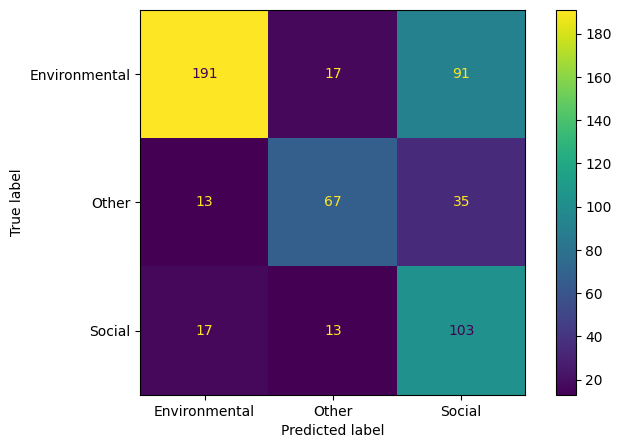

/var/folders/sx/v0b032tx7bbc5q8zz8w9wk740000gn/T/ipykernel_14996/189622929.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([stats])], ignore_index=True)


In [32]:
experiment_name = input("Enter experiment name: ")
predictions = clf.predict(X_test)
stats = evaluate_model(y_test, predictions, clf)
log_experiment_results(experiment_name, stats["macro avg"])

## What's next?
### Fundamental limitations of the BOW approach
1. We're just counting words, which means we don't consider the order of words in a sentence.
2. Lots of OOV tokens that are modelled incorrectly, which we don't like.
3. We are using every word with equal weight, while some words are more important than others
